In [9]:
import os
import librosa
import math
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [2]:
dataset_path = r"/home/sheeru/Documents/ML Datasets/music/genres_original"
json_path = r"data.json"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [10]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048,
             hop_length=512, num_segments=5):
    # Data storage dictionary
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_ps = int(SAMPLES_PER_TRACK/num_segments) # ps = per segment
    expected_vects_ps = math.ceil(samples_ps/hop_length)

    # loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensuring not at root
        if dirpath is not dataset_path:
            # save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]
            data["mapping"].append(semantic_label)
            # print(f"Processing: {semantic_label}")

            # process files for specific genre
            for f in filenames:
                if f == str("jazz.00054.wav"):
                    # As librosa only read files <1Mb
                    continue
                else:
                    # load audio file
                    file_path = os.path.join(dirpath, f)
                    signal,sr = librosa.load(file_path,sr=SAMPLE_RATE)
                    for s in range(num_segments):
                        start_sample = samples_ps * s
                        finish_sample = start_sample + samples_ps

                        mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                                    sr = sr,
                                                    n_fft = n_fft,
                                                    n_mfcc = n_mfcc,
                                                    hop_length = hop_length)

                        mfcc = mfcc.T

                        # store mfcc if it has expected length
                        if len(mfcc)==expected_vects_ps:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            # print(f"{file_path}, segment: {s+1}")

                        else:
                            print(file_path, len(mfcc), expected_vects_ps)

    with open(json_path,"w") as f:
        json.dump(data,f,indent=4)

In [11]:
save_mfcc(dataset_path,json_path,num_segments=10)
# clear_output()

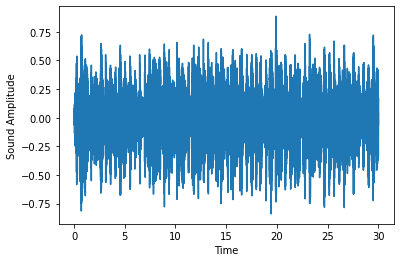

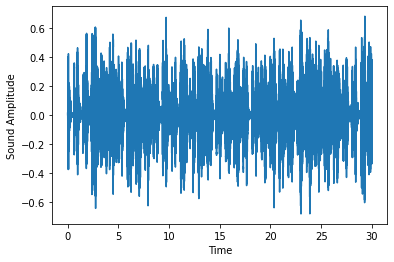

In [12]:
filepath = r"/home/sheeru/Documents/ML Datasets/music/genres_original/blues/blues.0000"
for i in range(2):
    audio, sfreq = librosa.load(filepath+str(i)+".wav")
    time = np.arange(0, len(audio))/sfreq
    plt.plot(time,audio)
    plt.xlabel("Time")
    plt.ylabel("Sound Amplitude")
    plt.show()

In [3]:
import json
import numpy as np

# load data
def load_data(dataset_path):
    with open(dataset_path,"r") as f:
        data = json.load(f)

    # Convert list to numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    return inputs,targets

inputs,targets = load_data(r"./data.json")
print(len(targets))

9986


In [4]:
# splitting the data
from sklearn.model_selection import train_test_split

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)
print(input_train.shape, target_train.shape)

(6990, 130, 13) (6990,)


In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

model = Sequential()
model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1690)              0         
                                                                 
 dense (Dense)               (None, 512)               865792    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 1,014,218
Trainable params: 1,014,218
Non-trainable params: 0
_________________________________________________________________


2021-11-19 19:28:11.496422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-19 19:28:11.544864: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-11-19 19:28:11.544883: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-11-19 19:28:11.545602: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [8]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)
clear_output()

Epoch 1/50
219/219 [==============================] - 1s 5ms/step - loss: 0.1427 - accuracy: 0.9572 - val_loss: 2.6858 - val_accuracy: 0.5985

NameError: name 'clear_output' is not defined

<Figure size 1440x1080 with 0 Axes>

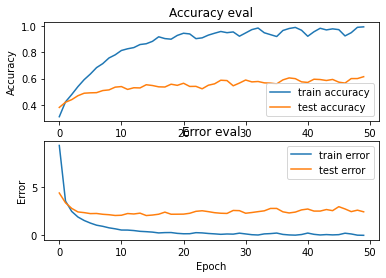

In [7]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()
plot_history(hist)

In [11]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 [==============================] - 0s 1ms/step - loss: 3.4212 - accuracy: 0.6368
Test accuracy: 0.6368491053581238


In [12]:
import tensorflow.keras as keras
# Overfitting
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1690)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               865792    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)               

<Figure size 1440x1080 with 0 Axes>

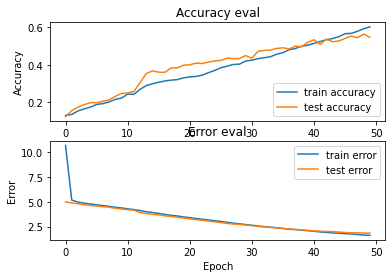

In [13]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)

clear_output()
plot_history(hist)

In [14]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 [==============================] - 0s 2ms/step - loss: 1.8542 - accuracy: 0.5474
Test accuracy: 0.5473965406417847


In [15]:
def prepare_dataset(test_size, validation_size):
    X,y = load_data(r"./data.json")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)

(130, 13, 1)


In [16]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 64)        256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                      

In [17]:
model.compile(optimizer=adam,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 epochs = 40,
                 batch_size = 32)

Epoch 1/40
188/188 [==============================] - 6s 28ms/step - loss: 1.9681 - accuracy: 0.3225 - val_loss: 1.6032 - val_accuracy: 0.4312

<Figure size 1440x1080 with 0 Axes>

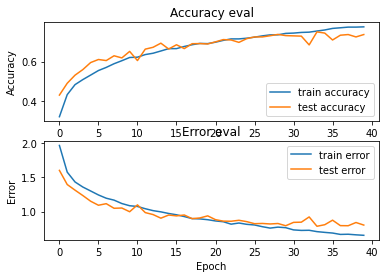

In [18]:
plot_history(hist)

In [19]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

79/79 [==============================] - 0s 6ms/step - loss: 0.8476 - accuracy: 0.7321
Test accuracy: 0.732078492641449


In [20]:
def predict(model, X, y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")
predict(model, X_test[10], y_test[10])


Expected index: 1, Predicted index: [1]
